In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
scaffold_path = "data/ragtag.agp"

In [3]:
def generate_ranges(max, window_size, increment):
    ranges = []
    start = 0
    end = window_size
    midpoint = (start + end) // 2
    
    ranges.append((start, end, midpoint))
    while end < max:
        start += increment
        end += increment
        midpoint = (start + end) // 2

        ranges.append((start, end, midpoint))

    return ranges

def calculate_bins(df, ranges):

    data_dict = dict()
    
    for n, range in enumerate(ranges):
        subset = df[(df.chr_position > range[0]) & (df.chr_position < range[1])]


        average = 0 
        
        if len(subset) > 0:
            average =  subset.largestAlternativeAlleleFrequency.mean()
        
        data_dict[n] = [ range[0], range[1], range[2], len(subset), average]

    output_df = pd.DataFrame(data_dict).transpose()
    output_df.columns = ["start", "end", "midpoint", "counts", "average"]

    return output_df

In [4]:
def generate_data(snp_path, scaffold_path, chromosome, chromosome_size, window_size, window_overlap, n_plants=1):
    snp_df = pd.read_csv(snp_path, sep='\t')
    snp_df.columns = ["contig",	"position",	"refBase",	"altBase",	"refAlleleFrequency",	"largestAlternativeAlleleFrequency",	"coverage"]
    snp_data = snp_df[["contig", "position", "largestAlternativeAlleleFrequency"]]
    snp_data = snp_data[snp_data.largestAlternativeAlleleFrequency.astype(int) > 0]

    ragtag_contig_ordering = pd.read_csv(scaffold_path, sep='\t', header=None, names=["chromosome", "chr_start", "chr_end", "part_number", "component_type", "contig", "contig_start", "contig_end", "orientation"])

    # filter ragtag to contigs mapped to s1
    ragtag_s1 = ragtag_contig_ordering[(ragtag_contig_ordering.chromosome == chromosome) & (ragtag_contig_ordering.contig.map(lambda x: x.startswith("utg")))] 
    
    # get chromosome start position of all contigs on s1
    position_corrector = dict(zip(ragtag_s1.contig.to_list(), ragtag_s1.chr_start.to_list())) 
    
    # filter snp data to contigs on s1
    s1_snp_data = snp_data[snp_data.contig.isin(ragtag_s1.contig)]
    
    # calculate chromosomal position of each snp
    s1_snp_data["chr_position"] = s1_snp_data.position + s1_snp_data.contig.map(position_corrector)
    
    s1_snp_data.sort_values(by="chr_position", inplace=True)
    
    chr_ranges = generate_ranges(chromosome_size, window_size, window_overlap)
    binned = calculate_bins(s1_snp_data, chr_ranges)


    density_peak = binned.counts.idxmax()
    peak_start = binned.iloc[density_peak].start
    peak_end = binned.iloc[density_peak].end


    peak_snps = s1_snp_data[(s1_snp_data.chr_position > peak_start) & (s1_snp_data.chr_position < peak_end)]

    print(
    f"""
    Density Peak Information
    Range: {peak_start} - {peak_end}
    Region covered: {(peak_end - peak_start) / 1000000} Mb
    # of SNPs: {len(peak_snps)} SNPs
    # of contigs: {len(peak_snps.contig.unique())}
    contigs: {peak_snps.contig.unique()}
    """)

    print(peak_snps)
    
    return  np.asarray(binned.midpoint) / 1000000, np.asarray(binned.counts) / n_plants


# 200H Bulk Suscpetible and Resistant


    Density Peak Information
    Range: 35000000.0 - 45000000.0
    Region covered: 10.0 Mb
    # of SNPs: 12 SNPs
    # of contigs: 1
    contigs: ['utg000462l']
    
         contig  position  largestAlternativeAlleleFrequency  chr_position
832  utg000462l    798805                                1.0      36650490
833  utg000462l   1565769                                1.0      37417454
836  utg000462l   3972250                                1.0      39823935
837  utg000462l   4596518                                1.0      40448203
838  utg000462l   5577420                                1.0      41429105
839  utg000462l   7583381                                1.0      43435066
840  utg000462l   7583382                                1.0      43435067
841  utg000462l   7583400                                1.0      43435085
842  utg000462l   7583762                                1.0      43435447
843  utg000462l   7583780                                1.0      43435465
844  u

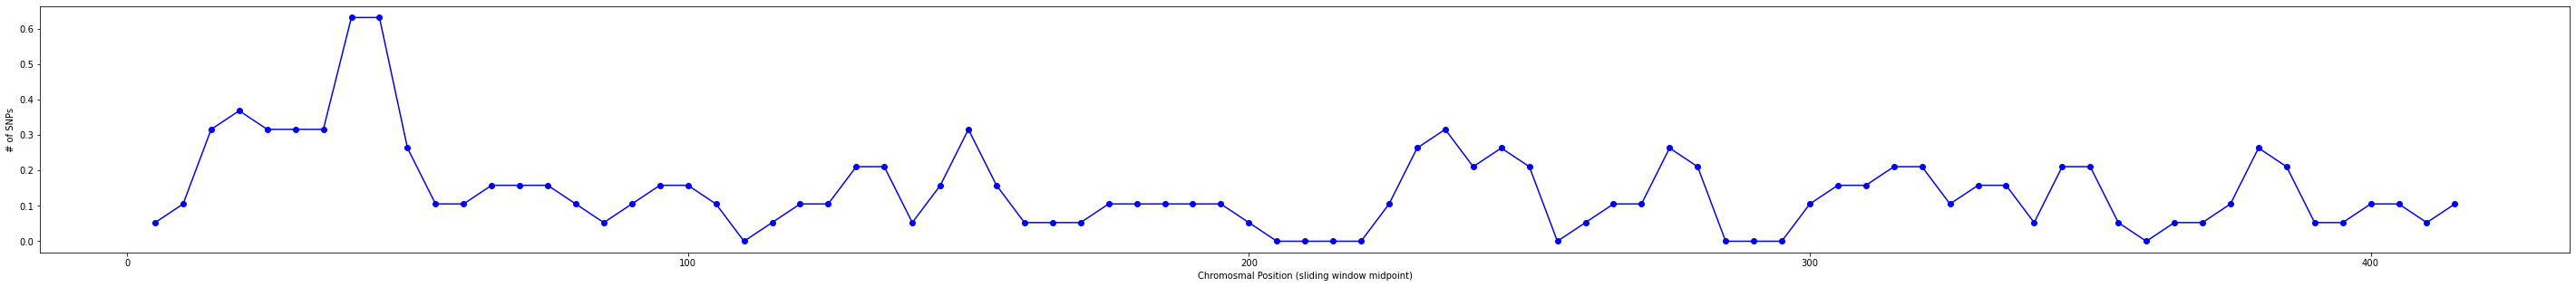

In [5]:
s_200h = generate_data("data/200h.snp.txt", scaffold_path, "LR880966.1_RagTag", 416428312, 10000000, 5000000, 19)

fig, ax = plt.subplots(figsize=(50,5))
plt.ylabel("# of SNPs")
plt.xlabel("Chromosmal Position (sliding window midpoint)")
plt.plot(*s_200h, "blue")
plt.scatter(*s_200h, color="blue")

plt.show()


    Density Peak Information
    Range: 35000000.0 - 45000000.0
    Region covered: 10.0 Mb
    # of SNPs: 30 SNPs
    # of contigs: 1
    contigs: ['utg000462l']
    
          contig  position  largestAlternativeAlleleFrequency  chr_position
7643  utg000462l    145017                                1.0      35996702
7644  utg000462l    146514                                1.0      35998199
7645  utg000462l    486872                                1.0      36338557
7646  utg000462l    548691                                1.0      36400376
7647  utg000462l   1364030                                1.0      37215715
7648  utg000462l   1569133                                1.0      37420818
7649  utg000462l   2730559                                1.0      38582244
7650  utg000462l   3249600                                1.0      39101285
7651  utg000462l   3349868                                1.0      39201553
7652  utg000462l   4308942                                1.0      4016

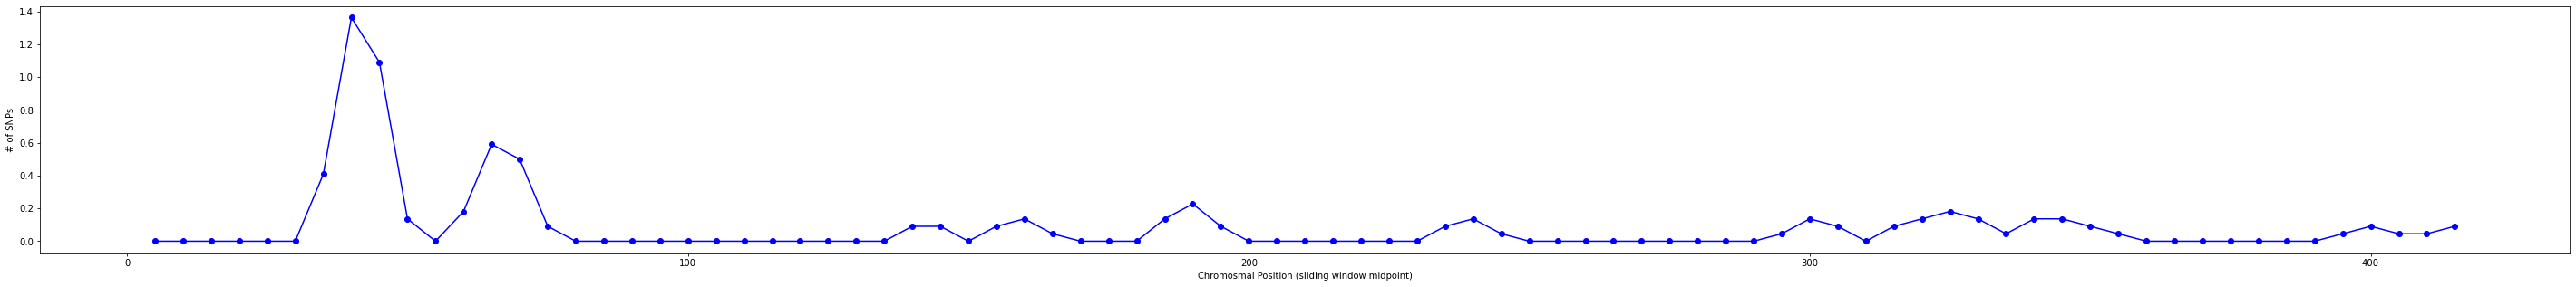

In [6]:
s_267d = generate_data("data/267d.snp.txt", scaffold_path, "LR880966.1_RagTag", 416428312, 10000000, 5000000, 22)

fig, ax = plt.subplots(figsize=(50,5))
plt.ylabel("# of SNPs")
plt.xlabel("Chromosmal Position (sliding window midpoint)")
plt.plot(*s_267d, "blue")
plt.scatter(*s_267d, color="blue")

plt.show()


    Density Peak Information
    Range: 35000000.0 - 45000000.0
    Region covered: 10.0 Mb
    # of SNPs: 10 SNPs
    # of contigs: 1
    contigs: ['utg000462l']
    
          contig  position  largestAlternativeAlleleFrequency  chr_position
1006  utg000462l   7583219                                1.0      43434904
1012  utg000462l   7583430                                1.0      43435115
1014  utg000462l   7583527                                1.0      43435212
1015  utg000462l   7583542                                1.0      43435227
1018  utg000462l   7583583                                1.0      43435268
1019  utg000462l   7583762                                1.0      43435447
1020  utg000462l   7583780                                1.0      43435465
1021  utg000462l   7583800                                1.0      43435485
1022  utg000462l   7583801                                1.0      43435486
1023  utg000462l   7616168                                1.0      4346

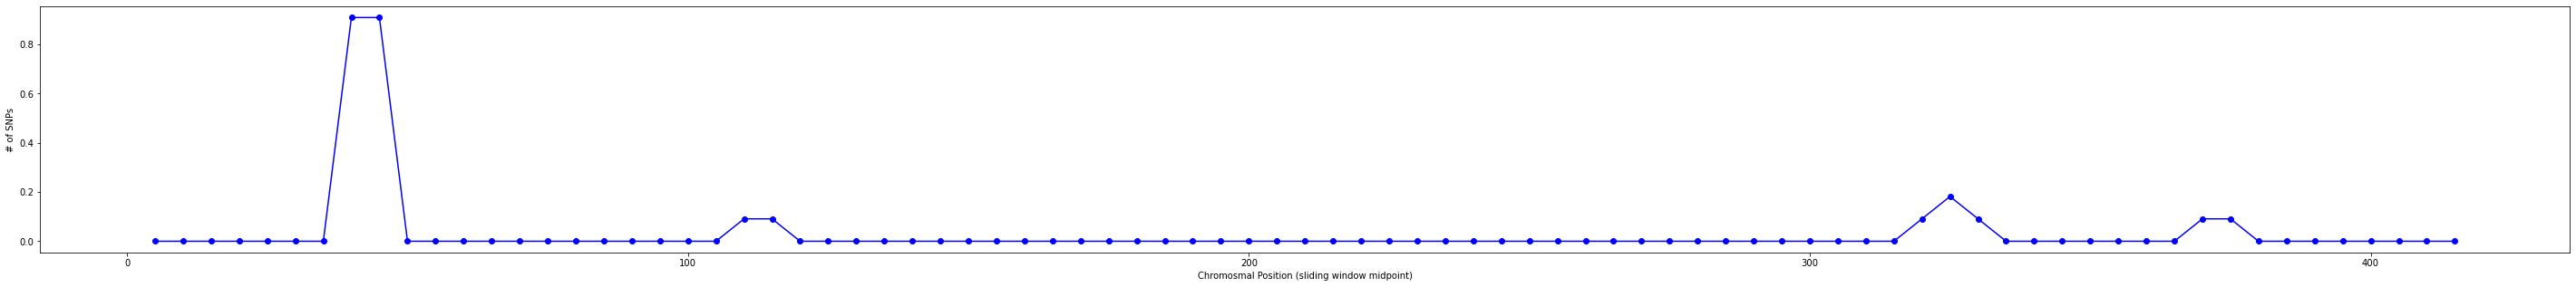

In [8]:
s_190d = generate_data("data/190d.snp.txt", scaffold_path, "LR880966.1_RagTag", 416428312, 10000000, 5000000, 11)

fig, ax = plt.subplots(figsize=(50,5))
plt.ylabel("# of SNPs")
plt.xlabel("Chromosmal Position (sliding window midpoint)")
plt.plot(*s_190d, "blue")
plt.scatter(*s_190d, color="blue")

plt.show()

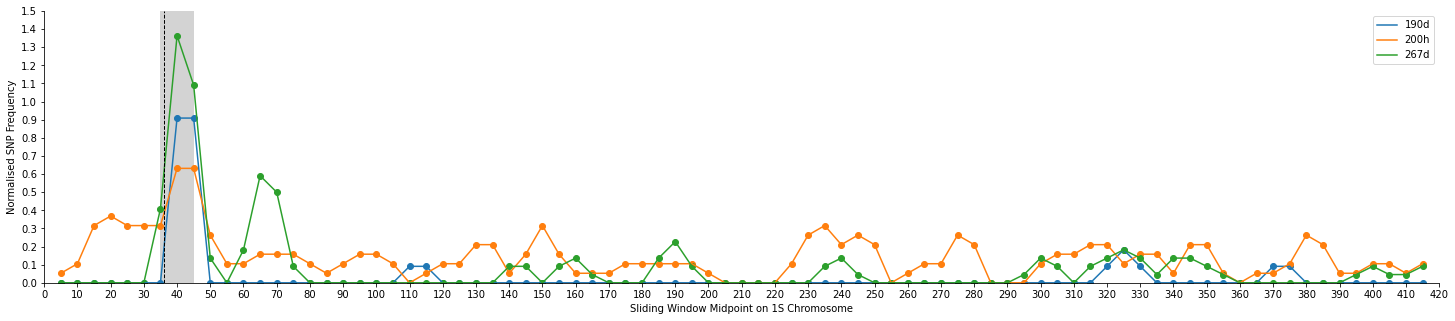

In [13]:
fig, ax = plt.subplots(figsize=(25,5))


# Plot window 
rect = patches.Rectangle((35000000 / 1000000, 0), 10000000 / 1000000, 1.5, linewidth=10, facecolor='lightgrey')
ax.add_patch(rect)

#plot 190d
ax.plot(*s_190d, label="190d")
ax.scatter(*s_190d)


# plot 200h
ax.plot(*s_200h, label="200h")
ax.scatter(*s_200h)



# Plot 267d
ax.plot(*s_267d, label="267d")
ax.scatter(*s_267d)

# Sr62 locus
ax.axvline(36025625/1000000, color='black', linestyle="--", linewidth=1)

# plot params
ax.set_ylim(ymin=0, ymax=1.5)
ax.set_ylabel("Normalised SNP Frequency")
ax.set_xlabel("Sliding Window Midpoint on 1S Chromosome")
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(axis='both', style='plain')
ax.locator_params(axis="y", nbins=15)
ax.locator_params(axis="x", nbins=50)
ax.set_xlim(0, 420000000/1000000)
plt.legend()

plt.savefig("figure_2", dpi=300)
plt.show()